# Linear Buckling Analysis of a 3D solid {far}`star`{far}`star`


```{admonition} Objectives
:class: objectives

In this numerical tour, we will demonstrate how to compute the buckling modes of a three-dimensional elastic solid under a conservative loading. The critical buckling loads and buckling modes are computed by solving a generalized non-hermitian eigenvalue problem using `slepc4py`.$\newcommand{\bq}{\boldsymbol{q}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bt}{\boldsymbol{t}}
\newcommand{\be}{\boldsymbol{e}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\T}{^{\text{T}}}$
```

```{admonition} Coauthors
:class: coauthors

This tour has been written with the help of:
* Maxime Pierre (Ecole des Ponts ParisTech, maxime.pierre@enpc.fr)
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./buckling_3d_solid.py>`
* {Download}`Jupyter notebook<./buckling_3d_solid.ipynb>`
* {Download}`Complete sources files<./buckling_3d_solid.zip>`
```

## Geometrically Nonlinear Elasticity

To formulate the buckling problem, we must consider a general geometrically nonlinear framework. More precisely, we will consider the case of small-strain/large displacements that are expected in typical buckling analysis. For more details on the theoretical formulation, the reader can refer to {cite:p}`nguyen2000stability`.


We consider the Green-Lagrange strain tensor $\be$ defined as:

$$e_{ij}  = \frac{1}{2} (u_{i,j} + u_{j,i}) + \frac{1}{2} u_{k,i}u_{k,j}$$

Note that this can be rewritten in tensor format as

$$ \be = \beps(\bu) + \dfrac{1}{2}\bq(\bu, \bu) $$

where we isolate the linear $\beps(\bu)=\frac{1}{2} (\nabla\bu+\nabla\T\bu)$ and nonlinear quadratic part $\bq(\bu, \bu)=\nabla\bu\T\nabla\bu$.

Since we restrict to a small strain assumption, we adopt a standard linear Hookean behavior for the material model (aka Saint-Venant Kirchhoff model) which can be described by the following quadratic elastic energy density:

$$ \psi(\be) = \dfrac{1}{2}\be:\mathbb{C}: \be $$

where $\mathbb{C}$ is the elastic moduli tensor.

We seek to find the underlying equilibrium displacement field $\bu$ as a function of a scalar loading parameter $\lambda$ under a set of prescribed external surface forces $\bt(\lambda)$.

## Equilibrium and stability conditions
Let us consider the total potential energy functional:

$$ \mathcal{E}_\text{pot}(\bu;\lambda) = \int_\Omega \psi(\be(\bu)) d\Omega - \int_{\Gamma_N} \bt(\lambda) \cdot \bu dS $$

The equilibrium equations are obtained from the first variation which must vanish:

$$ \partial_u\mathcal{E}_\text{pot}[\delta\bu] = \int_\Omega \be(\bu):\mathbb{C}:\delta\be[\delta\bu] d\Omega - \int_{\Gamma_N} \bt(\lambda) \cdot \delta\bu dS $$

where $\delta\bu$ is any kinematically admissible perturbation direction and where:

$$
\delta\be[\delta\bu] = \beps(\delta\bu) + \nabla\bu\T\nabla\delta\bu = \beps(\delta\bu) + \bq(\bu,\delta\bu)
$$

The stability conditions of an equilibrium are obtained from the Lejeune-Dirichlet theorem stating that the energy second variation must be positive. Here the second variation bilinear form is given by:

$$ \partial_{uu}\mathcal{E}_\text{pot}[\delta\bu,\delta \bv] = \int_\Omega (\delta \be[\delta\bv]:\mathbb{C}:\delta\be[\delta\bu] + \be:\mathbb{C}:\delta^2\be[\delta\bu,\delta\bv] )d\Omega $$

where:
$$
\delta^2\be[\delta\bu,\delta\bv] = \delta\bq(\bu,\delta \bu)[\delta\bv] = \nabla \delta\bv\T\nabla\delta\bu = \bq(\delta\bv,\delta\bu)
$$

## Bifurcation point

A given equilibrium solution $\lambda^c, \bu^c=\bu(\lambda^c)$ is a bifurcation point if the second variation vanishes for some $\delta\bu$. $\lambda^c$ defines the bifurcation load and $\delta\bu$ the bifurcation mode. Hence, we have:
$$
\int_\Omega ((\beps(\delta\bv) + \bq(\bu^c,\delta\bv)):\mathbb{C}:(\beps(\delta\bu) + \bq(\bu^c,\delta\bu)) + \be(\bu^c):\mathbb{C}:\bq(\delta\bv,\delta\bu))d\Omega = 0
$$

## Linear buckling analysis

When performing a linear buckling analysis, we look for bifurcation points on the fundamental equilibrium branch obtained by a small displacement assumption. As a result, in the above bifurcation equation the quadratic contribution in the first term can be neglected and the Green-Lagrange strain $\be(\bu^c)$ can be replaced by the linearized strain $\beps(\bu^c)$. Besides, in the small-displacement assumption, if the loading depends linearly on the load parameter $\lambda$, the small displacement solution also depends linearly on it. We therefore have $\bu^c= \lambda^c\bu_0$ and the bifurcation condition becomes:
$$
\int_\Omega (\beps(\delta\bv):\mathbb{C}:\beps(\delta\bu)  + \lambda^c\beps(\bu_0):\mathbb{C}:\bq(\delta\bv,\delta\bu))d\Omega = 0
$$

After, introducing the initial pre-stress $\bsig_0 = \mathbb{C}:\beps(\bu_0)$, the last term can be rewritten as $\bsig_0:\bq(\delta\bv,\delta\bu) = (\nabla \delta \bv) \bsig_0 (\nabla \delta\bu)\T$ so that :

```{math}
:label: buckling-weak-form
\int_\Omega (\beps(\delta\bv):\mathbb{C}:\beps(\delta\bu)  + \lambda^c(\nabla \delta \bv) \bsig_0 (\nabla \delta\bu)\T)d\Omega = 0
```

We recognize here a linear eigenvalue problem where the first term corresponds to the classical linear elasticity bilinear form and the second term is an additional contribution depending on the pre-stressed state $\bu_0$. Transforming this variational problem into matrix notations yields:
$$
[\mathbf{K}]+\lambda[\mathbf{K}_G(\bu_0)]=0
$$

where $[\mathbf{K}]$ is the classical linear elastic stiffness matrix and $[\mathbf{K}_G(\bu_0)]$ the so-called *geometrical stiffness* matrix.


## FEniCSx implementation

### Defining the Geometry

Here we will consider a fully three dimensional beam-like structure with length $L = 1$ and of rectangular cross-section with height $h = 0.01$, and width $b = 0.03$.

In [1]:
from dolfinx import mesh, fem, plot, default_scalar_type
from dolfinx.fem.petsc import LinearProblem, assemble_matrix
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from slepc4py import SLEPc
from eigenvalue_solver import solve_GEP_shiftinvert, EPS_get_spectrum
import numpy as np

L, b, h = 1, 0.01, 0.03
Nx, Ny, Nz = 51, 5, 5

domain = mesh.create_box(
    MPI.COMM_WORLD, [[0, 0, 0], [L, b, h]], [Nx, Ny, Nz], mesh.CellType.hexahedron
)

### Solving for the pre-stressed state $\bu_0$

We first need to compute the pre-stressed linear state $\bu_0$. It is obtained by solving a simple linear elasticity problem. The material is assumed here isotropic and we consider a pre-stressed state obtained from the application of a unit compression applied at the beam right end in the $X$ direction while the $Y$ and $Z$ displacement are fixed, mimicking a simple support condition. The beam is fully clamped on its left end.

In [2]:
E, nu = 1e3, 0.0

mu = fem.Constant(domain, default_scalar_type(E / 2 / (1 + nu)))
lmbda = fem.Constant(domain, default_scalar_type(E * nu / (1 + nu) / (1 - 2 * nu)))


def eps(v):
    return ufl.sym(ufl.grad(v))


def sigma(v):
    return lmbda * ufl.tr(eps(v)) * ufl.Identity(3) + 2 * mu * eps(v)


# Compute the linearized unit preload
N0 = 1
T = fem.Constant(domain, default_scalar_type((-N0, 0, 0)))
V = fem.FunctionSpace(domain, ufl.VectorElement("Lagrange", domain.ufl_cell(), 2))
v = ufl.TestFunction(V)
du = ufl.TrialFunction(V)


# Left and right ends of the beam
def left(x):
    return np.isclose(x[0], 0)


def right(x):
    return np.isclose(x[0], L)


# Dirichlet boundary conditions: Clamped and simply supported
fdim = domain.topology.dim - 1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
right_facets = mesh.locate_entities_boundary(domain, fdim, right)

u_L = np.array([0, 0, 0], dtype=default_scalar_type)
bcs = [
    fem.dirichletbc(u_L, fem.locate_dofs_topological(V, fdim, left_facets), V),
    fem.dirichletbc(
        default_scalar_type(0),
        fem.locate_dofs_topological(V.sub(1), fdim, right_facets),
        V.sub(1),
    ),
    fem.dirichletbc(
        default_scalar_type(0),
        fem.locate_dofs_topological(V.sub(2), fdim, right_facets),
        V.sub(2),
    ),
]

# Mark right facets for Neumann boundary condition application
facet_tag = mesh.meshtags(domain, fdim, right_facets, np.full_like(right_facets, 1))
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag)

# Linear Elasticity Bilinear Form
a = ufl.inner(sigma(du), eps(v)) * ufl.dx

# External loading on the right end
l = ufl.dot(T, v) * ds(1)

We will need the stiffness matrix in the linear buckling computation and hence we use `assemble_matrix` to assemble the matrix corresponding to our bilinear form.

In [3]:
# Solution of the trivial problem
problem = LinearProblem(
    a, l, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
u = problem.solve()

# Stiffness matrix
K = assemble_matrix(fem.form(a), bcs=bcs, diagonal=1)
K.assemble()

### Forming the geometric stiffness matrix and the buckling eigenvalue problem

From the previous solution, the prestressed state $\bsig_0$ entering the geometric stiffness matrix expression is simply given by `sigma(u)`. We therefore include directly the negative sign in the definition of the geometric stiffness form.

In contrast to the assembly of $\mathbf{K}$, we will put 0 on the diagonal of $\mathbf{K}_G$ in rows corresponding to boundary conditions. If we were to put 1 in both matrices, eigenvalues associated with the boundary conditions would be equal to 1 and pollute the spectrum. By putting 0 in $\mathbf{K}_G$, they will be equal to infinity instead.

In [4]:
kgform = -ufl.inner(sigma(u), ufl.grad(du).T * ufl.grad(v)) * ufl.dx

KG = assemble_matrix(fem.form(kgform), bcs=bcs, diagonal=0)
KG.assemble()

After having formed the geometric stiffness matrix, we will use `slepc4py` to solve a generalized eigenvalue problem $\mathbf{Ax}=\lambda \mathbf{Bx}$ with here $\mathbf{A}=\mathbf{K}$ and $\mathbf{B}=-\mathbf{K}_G$. Function defined in {Download}`eigenvalue_solver.py<./eigenvalue_solver.py>` allow to define the eigenvalue problem, set up parameters, monitor the resolution and extract the resulting eigenpairs. Here, our problem is of type `GHEP` (Generalized Hermitian eigenproblem), and we use a shift-and-invert transform: instead of solving $\mathbf{Ax}=\lambda \mathbf{Bx}$, we will solve
$$
(\mathbf{A}-\sigma\mathbf{B})^{-1}\mathbf{Bx} =\nu\mathbf{x}
$$
which has the same eigenvectors and for which the eigenvalues are
$$
\nu = 1/(\lambda-\sigma),
$$
meaning that the eigenvalues $\nu_i$ of largest magnitude correspond to the eigenvalues $\lambda_i$ closest to $\sigma$. Eigenvalues of large magnitude are easier to compute with a Krylov method, and thus the shift $\sigma$ should be chosen close to the eigenvalues we are trying to compute. Here, we will use a shift of 0.01, as the buckling points of interest are the smallest critical loads, i.e. the points corresponding to the smallest $\lambda_i$.

In [5]:
# Requested number of eigenvalues
N_eig = 3

# Solve eigenvalue problem
eigensolver = solve_GEP_shiftinvert(
    K,
    KG,
    problem_type=SLEPc.EPS.ProblemType.GHEP,
    solver=SLEPc.EPS.Type.KRYLOVSCHUR,
    nev=N_eig,
    tol=1e-12,
    shift=1e-2,
)

# Extract eigenpairs
(eigval, eigvec_r, eigvec_i) = EPS_get_spectrum(eigensolver, V)

******************************
***  SLEPc Iterations...   ***
******************************
Iter. | Conv. | Max. error
    1 |     3 | 2.7e-11

******************************
*** SLEPc Solution Results ***
******************************
Iteration number: 1
Converged eigenpairs: 3

Converged eigval.  Error 
----------------- -------
 1.68e-01             2.8e-13
 4.97e-01             9.6e-14
 9.88e-01             4.7e-14


In [6]:
# Analytical beam theory solution
# F_cr,n = alpha_n^2*EI/L^2
# where alpha_n are solutions to tan(alpha) = alpha
alpha = np.array([1.4303, 2.4509, 3.4709] + [(n + 1 / 2) for n in range(4, 10)]) * np.pi
I = b**3 * h / 12
S = b * h

for i in range(len(eigval)):
    critical_load_an = alpha[i] ** 2 * float(E * I / N0 / S) / L**2
    print(
        f"Critical load factor {i+1}: {eigval[i].real:.5f} FE | {critical_load_an:.5f} Beam"
    )

Critical load factor 1: 0.16818 FE | 0.16826 Beam
Critical load factor 2: 0.49671 FE | 0.49405 Beam
Critical load factor 3: 0.98842 FE | 0.99084 Beam


> Note that the analysis above is not limited to problems subject to Neumann boundary conditions.
One can equivalenty compute the prestress resulting from a displacement control simulation and the critical buckling load will correspond to the critical buckling displacement of the structure.

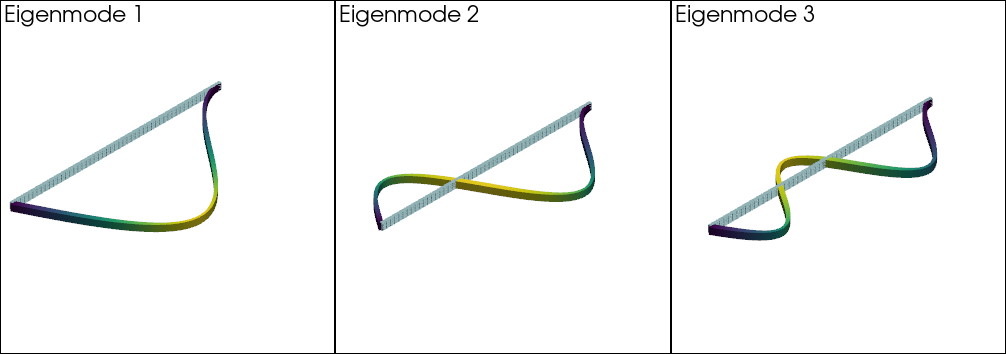

In [7]:
import pyvista

pyvista.set_jupyter_backend("static")

# Grid for the mesh
tdim = domain.topology.dim
mesh_topology, mesh_cell_types, mesh_geometry = plot.vtk_mesh(domain, tdim)
mesh_grid = pyvista.UnstructuredGrid(mesh_topology, mesh_cell_types, mesh_geometry)

# Grid for functions (2nd order elements)
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

# Plot the first 3 eigenmodes
pl = pyvista.Plotter(shape=(1, 3))
for i in range(3):
    pl.subplot(0, i)
    eigenmode = f"eigenmode_{i:02}"
    pl.add_text(
        f"Eigenmode {i+1}",
        font_size=12,
    )
    eigen_vector = eigvec_r[i]
    u_grid[eigenmode] = eigen_vector.x.array.reshape(
        u_geometry.shape[0], V.dofmap.index_map_bs
    )
    pl.add_mesh(mesh_grid, style="wireframe")
    pl.add_mesh(u_grid.warp_by_vector(eigenmode, factor=0.02), show_scalar_bar=False)
    pl.zoom_camera("tight")
    pl.view_isometric()
pl.show()

## References

```{bibliography}
:filter: docname in docnames
```